!!! note

    This notebook requires `pcg_skel` to be installed, which is an optional dependency of `paleo`. You can install it with `pip install pcg-skel`, or when installing `paleo` do `pip install paleo[skeleton]`.

This notebook will demonstrate how to use the extracted level2 graph edits
to skeletonize a neuron at every point in its history. This can be much faster than repeatedly skeletonizing the neuron from scratch, since much of the information used for skeletonization (e.g. level2 graph, node positions, etc) is reused across the history.


In [2]:
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from pcg_skel import pcg_skeleton, pcg_skeleton_direct
from tqdm import tqdm

from caveclient import CAVEclient
from paleo import (
    apply_edit,
    get_initial_graph,
    get_node_aliases,
    get_nucleus_supervoxel,
    get_root_level2_edits,
)

root_id = 864691135639556411

client = CAVEclient("minnie65_public", version=1078)

total_time = time.time()

## Collecting the necessary ingredients

We'll start by using some common functions in `paleo` to extract the edit history of a neuron, the initial state of all objects in its history, and some information about the neuron's nucleus. See the example notebooks on [edit extraction](../tutorials/extraction.ipynb) and [edit replay](../tutorial/replay.ipynb) for more context.


In [3]:
currtime = time.time()
edits = get_root_level2_edits(root_id, client)
get_edit_time = time.time() - currtime
print(f"{get_edit_time:.3f} seconds elapsed to get edits.")

currtime = time.time()
initial_graph = get_initial_graph(root_id, client)
get_graph_time = time.time() - currtime
print(f"{get_graph_time:.3f} seconds elapsed to get initial graph.")

currtime = time.time()

nuc_supervoxel_id = get_nucleus_supervoxel(root_id, client)

node_info = get_node_aliases(nuc_supervoxel_id, client, stop_layer=2)

nuc_table = client.info.get_datastack_info()["soma_table"]
nuc_info = client.materialize.query_table(
    nuc_table, filter_equal_dict=dict(pt_root_id=root_id)
)
nuc_loc = nuc_info["pt_position"].values[0]

get_nuc_info_time = time.time() - currtime
print(f"{get_nuc_info_time:.3f} seconds elapsed to get nucleus info.")

Extracting level2 edits:   0%|          | 0/693 [00:00<?, ?it/s]

98.200 seconds elapsed to get edits.


Getting initial graph:   0%|          | 0/309 [00:00<?, ?it/s]

46.651 seconds elapsed to get initial graph.
2.393 seconds elapsed to get nucleus info.


While this part isn't strictly necessary, here I'll show how to replay edits on a neuron.
This is helpful here for knowing which level2 nodes actually ever make it into our neuron
of interest.


In [4]:
def find_level2_node(graph, level2_ids):
    for level2_id in level2_ids:
        if graph.has_node(level2_id):
            return level2_id
    return None


currtime = time.time()

graph = initial_graph.copy()

# keep track of components that are reached as we go
components = []

# store the initial state
nucleus_node_id = find_level2_node(graph, node_info.index)
component = nx.node_connected_component(graph, nucleus_node_id)
components.append(component)

# after each edit, apply it and store the connected component for the nucleus node
for edit_id, edit in tqdm(edits.items(), disable=False):
    apply_edit(graph, edit)
    nucleus_node_id = find_level2_node(graph, node_info.index)
    component = nx.node_connected_component(graph, nucleus_node_id)
    components.append(component)

# component_masks = get_component_masks(components)
used_l2_ids = np.unique(np.concatenate([list(c) for c in components]))

get_used_time = time.time() - currtime
print(f"{get_used_time:.3f} seconds elapsed to get used level2 ids.")

100%|██████████| 693/693 [00:02<00:00, 254.35it/s]


4.319 seconds elapsed to get used level2 ids.


Now, for every level2 node that gets used in this neuron's history, we will use the level2 cache to get the node's position.


In [5]:
def get_l2data(level2_ids):
    l2_data = client.l2cache.get_l2data(
        level2_ids,
        attributes=["area_nm2", "max_dt_nm", "mean_dt_nm", "size_nm3", "rep_coord_nm"],
    )

    l2_nodes = pd.DataFrame(l2_data).T
    l2_nodes.index = l2_nodes.index.astype(int)
    l2_nodes["x"] = l2_nodes["rep_coord_nm"].apply(lambda x: x[0])
    l2_nodes["y"] = l2_nodes["rep_coord_nm"].apply(lambda x: x[1])
    l2_nodes["z"] = l2_nodes["rep_coord_nm"].apply(lambda x: x[2])
    l2_nodes.drop(columns=["rep_coord_nm"], inplace=True)
    return l2_nodes


currtime = time.time()

l2data = get_l2data(used_l2_ids)

get_l2data_time = time.time() - currtime
print(f"{get_l2data_time:.3f} seconds elapsed to get l2 data.")

6.287 seconds elapsed to get l2 data.


## Skeletonizing

Finally, we have all of the ingredients we need to skeletonize the neuron at every point in its history. At this point, we are done with API calls since we collected all the information we need ahead of time. With this in hand, we can call `pcg_skeleton_direct` to apply the TEASAR algorithm to skeletonize the neuron at every point in its history.


In [6]:
def skeletonize(graph):
    nucleus_node_id = find_level2_node(graph, node_info.index)
    component = nx.node_connected_component(graph, nucleus_node_id)
    subgraph = graph.subgraph(component)
    component = pd.Index(list(component))
    vertices = l2data.loc[component, ["x", "y", "z"]].values
    edges = nx.to_pandas_edgelist(subgraph).values
    edges = np.vectorize(component.get_loc)(edges)
    print(len(edges))
    skeleton = pcg_skeleton_direct(vertices, edges, root_point=nuc_loc)
    return skeleton


currtime = time.time()

graph = initial_graph.copy()

skeletons = {}

# initial skeleton
skeleton = skeletonize(graph)
skeletons[-1] = skeleton

# skeletons as we edit
for edit_id, edit in tqdm(edits.items(), desc="Skeletonizing states", disable=True):
    apply_edit(graph, edit)
    skeleton = skeletonize(graph)
    skeletons[edit_id] = skeleton

skeletonize_time = time.time() - currtime

print(f"{skeletonize_time:.3f} seconds elapsed to skeletonize.")

total_time = time.time() - total_time

71
71
71
71
71
71
71
71
71
71
71
71
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579
4579

In [7]:
print(f"Total time: {total_time:.0f} seconds\n")
get_edits_prop = get_edit_time / total_time
get_graph_prop = get_graph_time / total_time
get_nuc_info_prop = get_nuc_info_time / total_time
get_used_prop = get_used_time / total_time
get_l2data_prop = get_l2data_time / total_time
skeletonize_prop = skeletonize_time / total_time

print(f"Get edits: {get_edits_prop:.0%}, {get_edit_time:.0f} seconds")
print(f"Get initial graph: {get_graph_prop:.0%}, {get_graph_time:.0f} seconds")
print(f"Get nucleus info: {get_nuc_info_prop:.0%}, {get_nuc_info_time:.0f} seconds")
print(f"Get used level2 ids: {get_used_prop:.0%}, {get_used_time:.0f} seconds")
print(f"Get l2 data: {get_l2data_prop:.0%}, {get_l2data_time:.0f} seconds")
print(f"Skeletonize: {skeletonize_prop:.0%}, {skeletonize_time:.0f} seconds")

Total time: 280 seconds

Get edits: 35%, 98 seconds
Get initial graph: 17%, 47 seconds
Get nucleus info: 1%, 2 seconds
Get used level2 ids: 2%, 4 seconds
Get l2 data: 2%, 6 seconds
Skeletonize: 44%, 122 seconds


## Compare to skeletonizing from scratch

Let's make sure that the skeletonization we did from the history is consistent with
what we would have gotten if we skeletonized from scratch.


In [8]:
# pick an edit to check
edit_id = 532299

# note: this would have to be adjusted for other edits, where roots[1] may not be the
# nucleus root ID
root_after_op = client.chunkedgraph.get_operation_details([edit_id])[str(edit_id)][
    "roots"
][1]

currtime = time.time()
scratch_skeleton = pcg_skeleton(
    root_after_op,
    client,
    root_point=nuc_loc,
    root_point_resolution=[1, 1, 1],
)
print(f"{time.time() - currtime:.3f} seconds elapsed to skeletonize once from scratch.")

7.577 seconds elapsed to skeletonize once from scratch.


In [9]:
history_skeleton = skeletons[edit_id]

Let's check if these skeletons are isomorphic - since nodes/edges may not have a
consistent ordering, we'll sort the nodes by position and use that order to reindex the
edges before comparing. We see that the two skeletons have identical node positions.


In [10]:
history_skeleton_nodes = pd.DataFrame(history_skeleton.vertices).sort_values([0, 1, 2])
scratch_skeleton_nodes = pd.DataFrame(scratch_skeleton.vertices).sort_values([0, 1, 2])
(history_skeleton_nodes.values == scratch_skeleton_nodes.values).all()

True

And identical edges.


In [11]:
history_skeleton_edges = history_skeleton.edges
history_skeleton_edges = np.vectorize(history_skeleton_nodes.index.get_loc)(
    history_skeleton_edges
)

scratch_skeleton_edges = scratch_skeleton.edges
scratch_skeleton_edges = np.vectorize(scratch_skeleton_nodes.index.get_loc)(
    scratch_skeleton_edges
)

(history_skeleton_edges == scratch_skeleton_edges).all()

True

## Computing features

As an example of why this process can be useful, let's see how some topological
properties of the neuron evolved over the course of proofreading.


In [12]:
skeleton_info = []
for i, (operation_id, skeleton) in enumerate(skeletons.items()):
    skeleton_info.append(
        {
            "state": i,
            "operation_id": operation_id,
            "n_vertices": len(skeleton.vertices),
            "n_edges": len(skeleton.edges),
            "path_length": skeleton.path_length(),
            "n_branch_points": len(skeleton.branch_points),
            "n_end_points": len(skeleton.end_points),
        }
    )

skeleton_info = pd.DataFrame(skeleton_info)

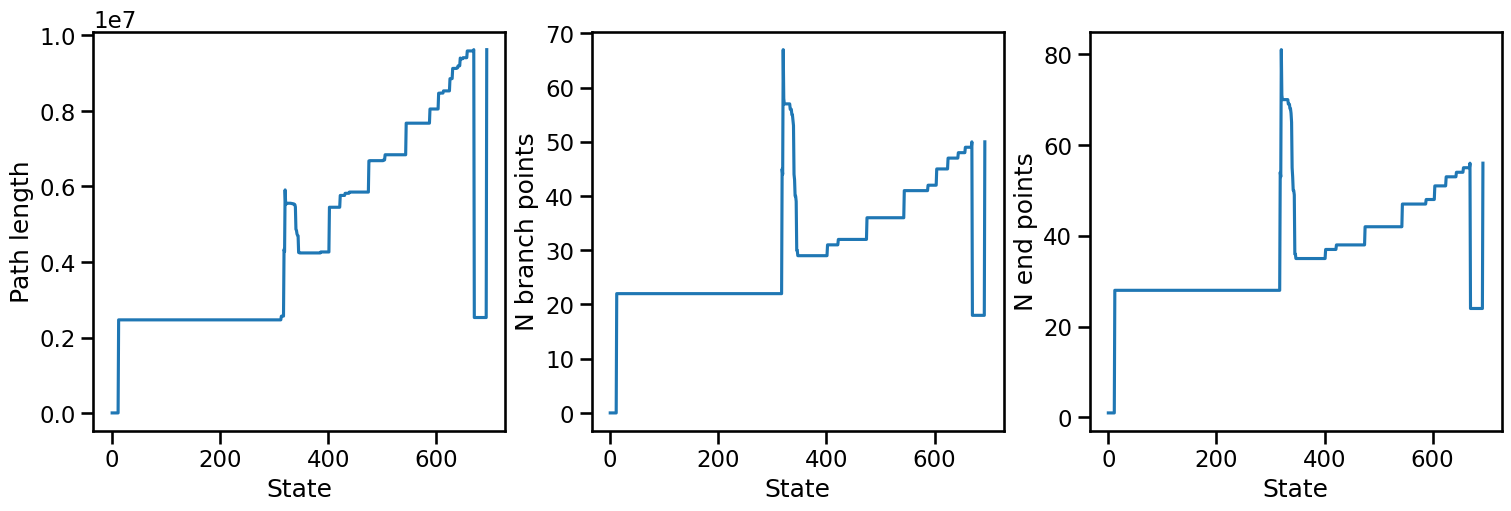

In [13]:
sns.set_context("talk")
fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout="constrained")
for i, feature in enumerate(["path_length", "n_branch_points", "n_end_points"]):
    sns.lineplot(data=skeleton_info, x="state", y=feature, ax=axs[i])
    axs[i].set_ylabel(feature.capitalize().replace("_", " "))
    axs[i].set_xlabel("State")

In [14]:
import pyvista as pv

plotter = pv.Plotter()
plotter.open_gif("skeleton_evolution.gif", fps=30)


def skel_to_poly(skeleton):
    vertices = skeleton.vertices
    edges = skeleton.edges
    lines = np.full((len(edges), 3), 2)
    lines[:, 1:] = edges
    line_poly = pv.PolyData(vertices, lines=lines)
    return line_poly


last_skeleton = skeletons[list(skeletons.keys())[-1]]
actor = plotter.add_mesh(skel_to_poly(last_skeleton), color="black", line_width=2)
plotter.write_frame()
plotter.remove_actor(actor)

for edit_id, skeleton in skeletons.items():
    line_poly = skel_to_poly(skeleton)
    actor = plotter.add_mesh(line_poly, color="black", line_width=2)
    text = plotter.add_text(f"Edit {edit_id}", position="upper_edge", font_size=24)
    plotter.write_frame()
    plotter.remove_actor(actor)

plotter.close()

![](../../../skeleton_evolution.gif)
